In [1]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import math
import pandas as pd
import numpy as np
import random

import seaborn as sb
import scikitplot
from matplotlib import pyplot as plotGraph
from sklearn.metrics import classification_report, accuracy_score

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras.utils as np_utils
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocessing

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# get data

raf_fer2013_df = pd.read_csv("/content/drive/MyDrive/17644_MoodDetectives/Datasets/merged.csv")

# print number of images and display first 5 rows in dataframe
print("Number of images: ", len(raf_fer2013_df))

raf_fer2013_df.head(5)

Number of images:  51226


,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [5]:
# number of unique emotions in dataset
raf_fer2013_df.emotion.value_counts()

3    14946
6     9402
4     8537
0     5820
5     5621
2     5476
1     1424
Name: emotion, dtype: int64

<Axes: xlabel='emotion', ylabel='count'>

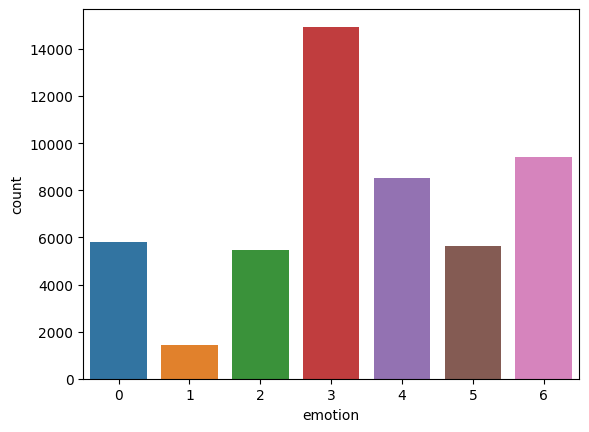

In [6]:
sb.countplot(x=raf_fer2013_df.emotion)

In [7]:
emotion_labels = {
    0: "anger",
    1: "disgust",
    2: "fear",
    3: "happy",
    4: "sad",
    5: "suprise",
    6: "neutral"
}

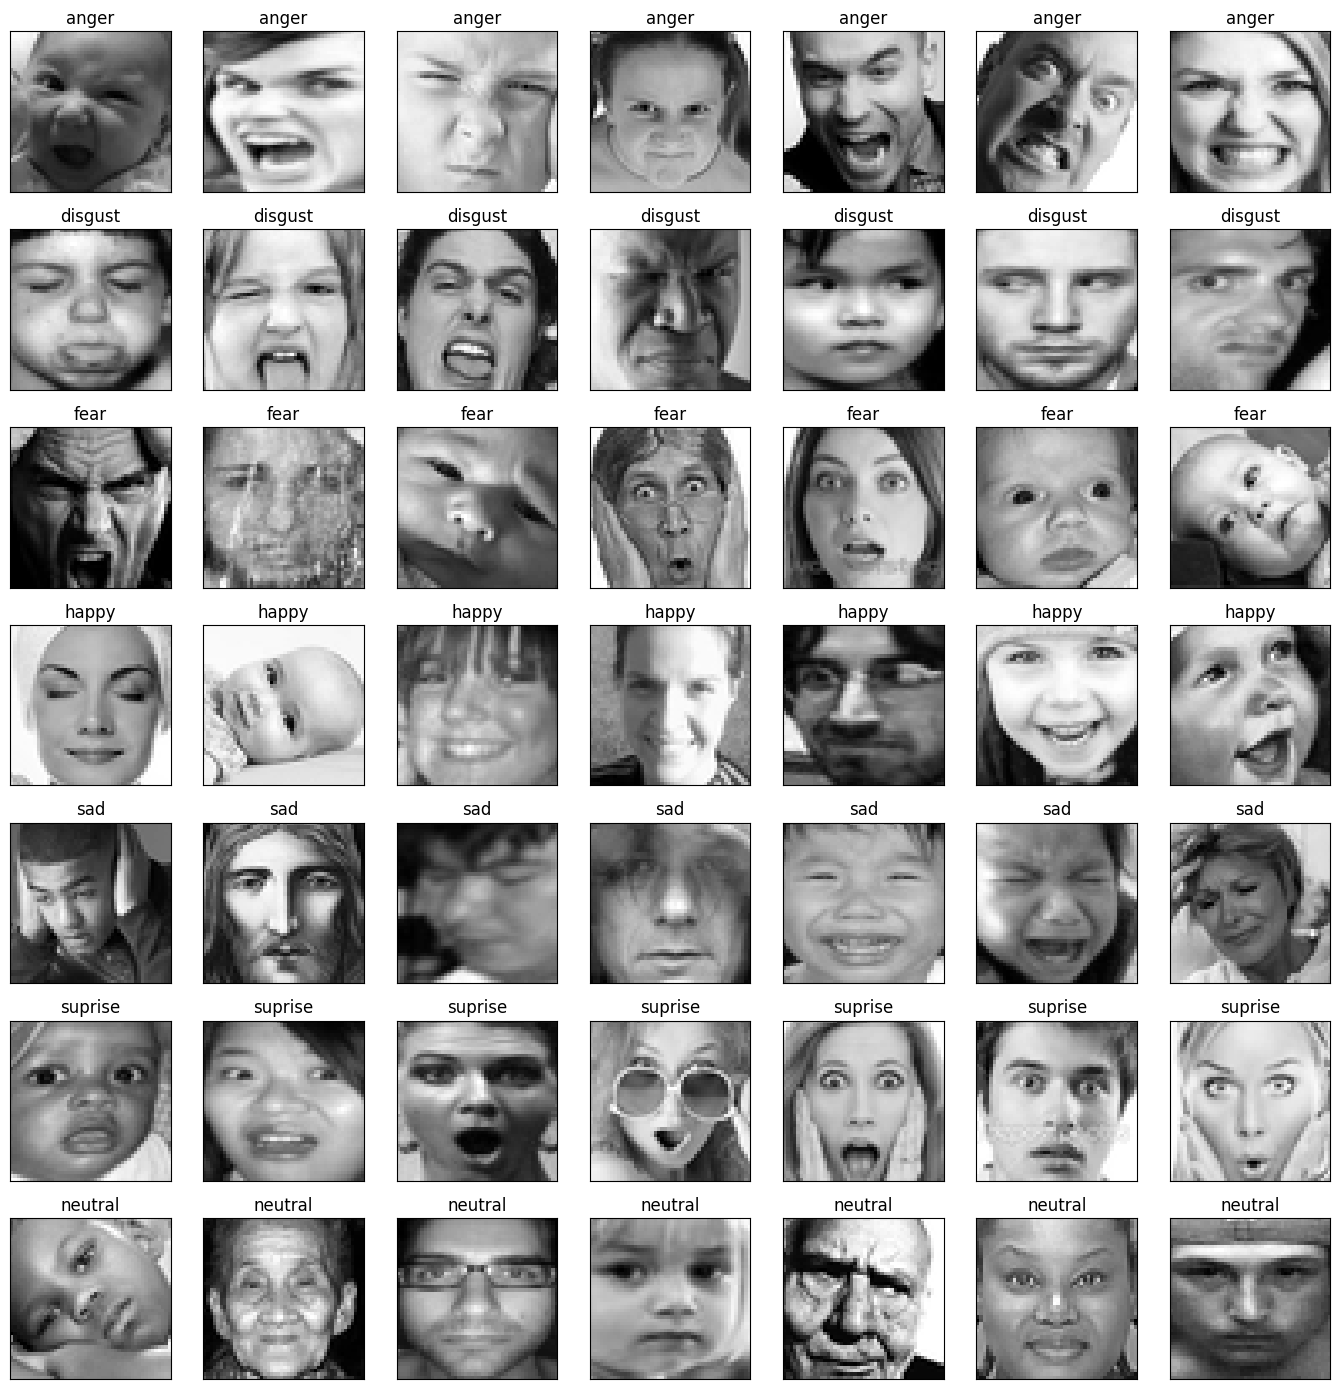

In [8]:
# display example images for each emotion in dataset
fig = plotGraph.figure(1,(14,14))



k = 0

for label in sorted(raf_fer2013_df.emotion.unique()):
  for j in range(7):

    random_pic = random.randint(0, raf_fer2013_df.emotion.value_counts()[label]-1)

    px = raf_fer2013_df[raf_fer2013_df.emotion == label].pixels.iloc[random_pic]
    px = np.array(px.split(" ")).reshape(48,48,1).astype("float32")

    k += 1

    ax = plotGraph.subplot(7,7,k)
    ax.imshow(px, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_title(emotion_labels[label])
    plotGraph.tight_layout()

In [9]:
img_array = raf_fer2013_df.pixels.apply(lambda x:
                                    np.array(x.split(" ")).reshape(48,48,1).astype(
                                        "float32"))

img_array = np.stack(img_array, axis=0)

img_array.reshape

<function ndarray.reshape>

In [10]:
le = LabelEncoder()
img_labels = le.fit_transform(raf_fer2013_df.emotion)
img_labels = np_utils.to_categorical((img_labels))
img_labels.shape

(51226, 7)

In [11]:
img_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

# Train Model (CNN)

In [12]:
# split data into train and test data

x_Train, x_Test, y_Train, y_Test = train_test_split(
    img_array,
    img_labels,
    shuffle=True,
    stratify = img_labels,
    test_size = .2,
    random_state=42
)

In [13]:
# normalize data
x_Train = x_Train/255
x_Test = x_Test/255

In [14]:
img_width = x_Train.shape[1]
img_height = x_Train.shape[2]
img_depth = x_Train.shape[3]

num_classes = y_Train.shape[1]

In [15]:
# build model

def buildnet(optim):
  net = Sequential(name="Seven_Emotion_CNN")

  net.add(
      Conv2D(
          filters=64,
          kernel_size=(5,5),
          input_shape = (img_width, img_height, img_depth),
          activation = "elu",
          padding = "same",
          kernel_initializer = "he_normal",
          name = "conv2d_1"
                )
  )
  net.add(BatchNormalization(name = "batchnorm_1"))

  net.add(
      Conv2D(
          filters=64,
          kernel_size=(5,5),
          activation = "elu",
          padding = "same",
          kernel_initializer = "he_normal",
          name = "conv2d_2"
                )
  )
  net.add(BatchNormalization(name = "batchnorm_2"))
  net.add(MaxPooling2D(pool_size=(2,2), name="maxpool2d_1"))
  net.add((Dropout(0.4, name="dropout_1")))

  net.add(
      Conv2D(
          filters=128,
          kernel_size=(3,3),
          activation = "elu",
          padding = "same",
          kernel_initializer = "he_normal",
          name = "conv2d_3"
                )
  )
  net.add(BatchNormalization(name = "batchnorm_3"))

  net.add(
      Conv2D(
          filters=128,
          kernel_size=(3,3),
          activation = "elu",
          padding = "same",
          kernel_initializer = "he_normal",
          name = "conv2d_4"
                )
  )
  net.add(BatchNormalization(name = "batchnorm_4"))
  net.add(MaxPooling2D(pool_size=(2,2), name="maxpool2d_2"))
  net.add((Dropout(0.4, name="dropout_2")))

  net.add(
      Conv2D(
          filters=256,
          kernel_size=(3,3),
          activation = "elu",
          padding = "same",
          kernel_initializer = "he_normal",
          name = "conv2d_5"
                )
  )
  net.add(BatchNormalization(name = "batchnorm_5"))

  net.add(
      Conv2D(
          filters=256,
          kernel_size=(3,3),
          activation = "elu",
          padding = "same",
          kernel_initializer = "he_normal",
          name = "conv2d_6"
                )
  )
  net.add(BatchNormalization(name = "batchnorm_6"))
  net.add(MaxPooling2D(pool_size=(2,2), name="maxpool2d_3"))
  net.add((Dropout(0.5, name="dropout_3")))

  net.add(Flatten(name = "flatten"))

  net.add(
      Dense(
          128,
          activation = "elu",
          kernel_initializer = "he_normal",
          name = "dense_1"

      )
  )

  net.add(BatchNormalization(name="batchnorm_7"))
  net.add(Dropout(0.6, name="dropout_4"))

  net.add(
      Dense(
          num_classes,
          activation = "softmax",
          kernel_initializer = "he_normal",
          name = "outter_layer"
      )
  )

  net.compile(
      loss="categorical_crossentropy",
      optimizer= optim,
      metrics = ["accuracy"]
  )

  net.summary()

  return net


In [16]:
batch_size = 32
epochs = 50
# epochs = 100
steps_per_epoch = len(x_Train)/batch_size



early_stopping = EarlyStopping(
    monitor = "val_accuracy",
    min_delta = 0.00005,
    patience = 11,
    verbose =1,
    restore_best_weights = True
    )

lr_scheduler = ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 7,
    min_lr = 1e-7,
    verbose = 1

)


google_path ="/content/drive/MyDrive/17644_MoodDetectives/23_Layer_CNN_Model/Seven_Emotions/MERGED/Checkpoints/"

model_checkpoints = ModelCheckpoint(
    filepath = google_path + "cnn_raf_fer2013_model_epoch{epoch}.h5",
    save_weights_only=False,
    save_freq = int(5* steps_per_epoch), # save model every 5 epochs
    # monitor = "val_accuracy",
    verbose = 1
    
)

callbacks = [
    early_stopping,
    lr_scheduler,
    model_checkpoints
]

In [17]:
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    shear_range = 0.15,
    zoom_range = 0.15,
    horizontal_flip = True
)

train_datagen.fit(x_Train)

In [18]:
optims = [
    optimizers.Nadam(
        learning_rate = .001,
        beta_1 = 0.9,
        beta_2 = 0.999,
        epsilon = 1e-07,
        name = "Nadam"
    ),
    optimizers.Adam(0.001),
]

In [19]:
model = buildnet(optims[1])

history = model.fit_generator(
    train_datagen.flow(x_Train, y_Train, batch_size = batch_size),
    validation_data = (x_Test, y_Test),
    steps_per_epoch = len(x_Train)/batch_size,
    epochs = epochs,
    callbacks = callbacks,
    use_multiprocessing = True
)
              

Model: "Seven_Emotion_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)  

<ipython-input-19-ad9034b8d9d3>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


1280/1280 [==============================] - 65s 37ms/step - loss: 1.8924 - accuracy: 0.2976 - val_loss: 1.4850 - val_accuracy: 0.4373 - lr: 0.0010
Epoch 2/50
1280/1280 [==============================] - 46s 36ms/step - loss: 1.5173 - accuracy: 0.4241 - val_loss: 1.4197 - val_accuracy: 0.4978 - lr: 0.0010
Epoch 3/50
1280/1280 [==============================] - 46s 36ms/step - loss: 1.3746 - accuracy: 0.4884 - val_loss: 1.1626 - val_accuracy: 0.5660 - lr: 0.0010
Epoch 4/50
1280/1280 [==============================] - 46s 36ms/step - loss: 1.2893 - accuracy: 0.5222 - val_loss: 1.1896 - val_accuracy: 0.5570 - lr: 0.0010
Epoch 5/50
1278/1280 [============================>.] - ETA: 0s - loss: 1.2327 - accuracy: 0.5466
Epoch 5: saving model to /content/drive/MyDrive/17644_MoodDetectives/23_Layer_CNN_Model/Seven_Emotions/MERGED/Checkpoints/cnn_raf_fer2013_model_epoch5.h5
1280/1280 [==============================] - 48s 38ms/step - loss: 1.2327 - accuracy: 0.5466 - val_loss: 1.0584 - val_accur

# Evaluate Model

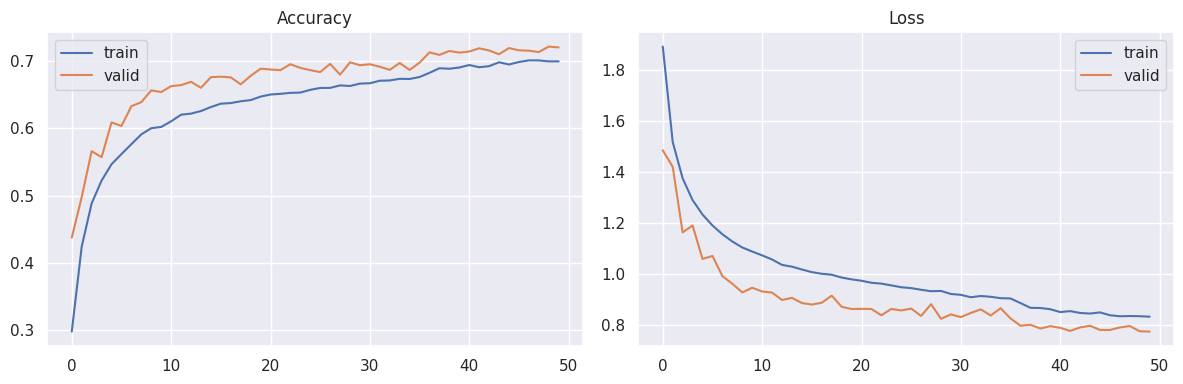

In [20]:
# metrics

sb.set()
figure = plotGraph.figure(0, (12,4))

# Plot Accuracy
ax = plotGraph.subplot(1,2,1)
sb.lineplot(
    x = history.epoch,
    y = history.history["accuracy"], 
    label="train"
)

sb.lineplot(
    x = history.epoch,
    y = history.history["val_accuracy"], 
    label="valid"
)

plotGraph.title("Accuracy")
plotGraph.tight_layout()

# Plot Loss
ax = plotGraph.subplot(1,2,2)
sb.lineplot(
    x = history.epoch,
    y = history.history["loss"], 
    label="train"
)

sb.lineplot(
    x = history.epoch,
    y = history.history["val_loss"], 
    label="valid"
)

plotGraph.title("Loss")
plotGraph.tight_layout()

In [21]:
# acccuracy

prediction = model.predict(x_Test)

accuracy_score( np.argmax(y_Test,axis=1) , np.argmax(prediction, axis =1) )

321/321 [==============================] - 2s 7ms/step


0.7202810853015811

321/321 [==============================] - 2s 7ms/step


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

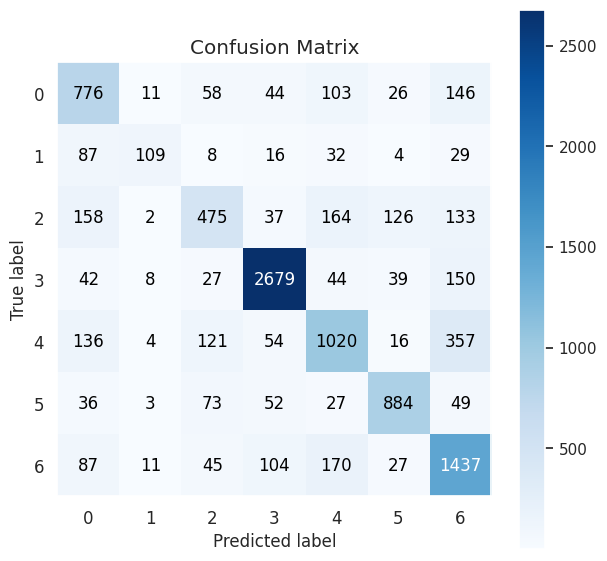

In [22]:
# Confusion Matrix

predictions = model.predict(x_Test)
class_predictions = np.argmax(predictions, axis=1)

scikitplot.metrics.plot_confusion_matrix(
    np.argmax(y_Test, axis=1),
    class_predictions,
    figsize=(7,7)
)

In [23]:
print(
    "Total Wrong Predictions:", 
      np.sum(
          np.argmax(y_Test, axis=1) != class_predictions
      )
    )

print(
    classification_report(
    np.argmax(y_Test, axis=1), class_predictions
    )
  )

Total Wrong Predictions: 2866
              precision    recall  f1-score   support

           0       0.59      0.67      0.62      1164
           1       0.74      0.38      0.50       285
           2       0.59      0.43      0.50      1095
           3       0.90      0.90      0.90      2989
           4       0.65      0.60      0.62      1708
           5       0.79      0.79      0.79      1124
           6       0.62      0.76      0.69      1881

    accuracy                           0.72     10246
   macro avg       0.70      0.65      0.66     10246
weighted avg       0.72      0.72      0.72     10246



1/1 [==============================] - 0s 26ms/step


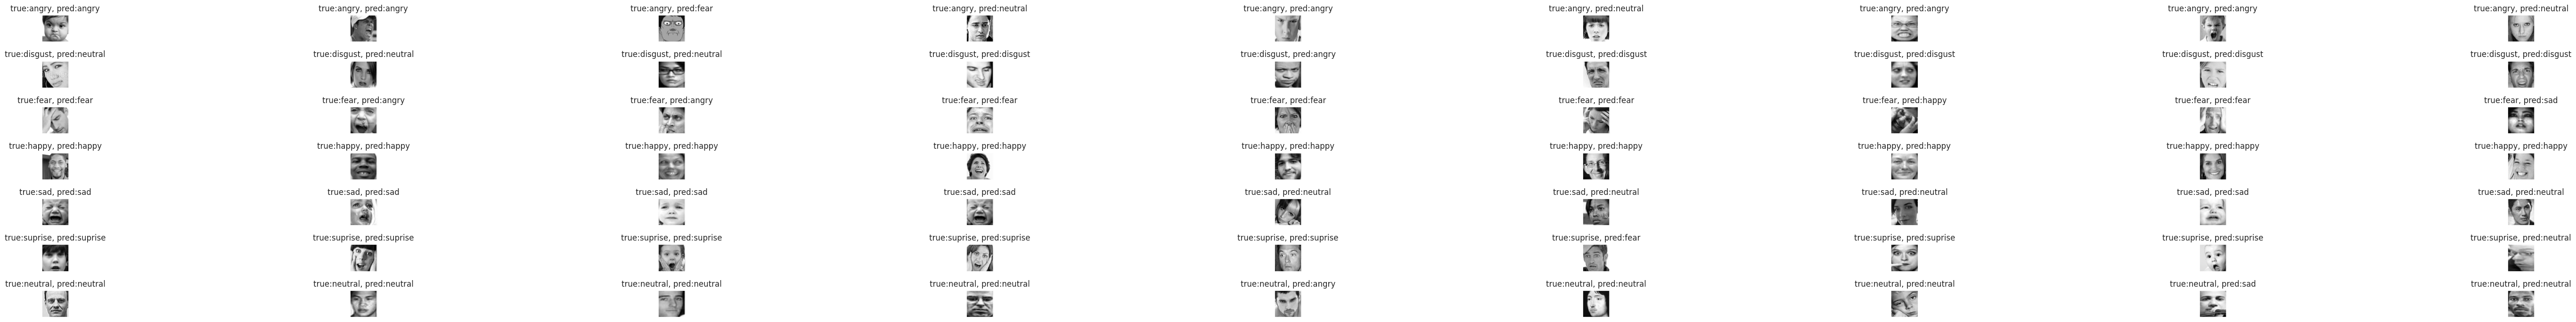

In [24]:
# check some images model got wrong
figure = plotGraph.figure(1, (63,7))

map_emotions ={
    0: "angry",
    1: "disgust",
    2: "fear",
    3: "happy",
    4: "sad",
    5: "suprise",
    6: "neutral"

}

np.random.seed(2)

random_angry_images = np.random.choice(
    np.where(y_Test[:,0] == 1)[0],
    size=9
)

random_disgust_images = np.random.choice(
    np.where(y_Test[:,1] == 1)[0],
    size=9
)
  

random_fear_images = np.random.choice(
    np.where(y_Test[:,2]==1)[0],
    size=9
    )

random_happy_images = np.random.choice(
    np.where(y_Test[:,3] == 1)[0],
    size=9
)

random_sad_images = np.random.choice(
    np.where(y_Test[:,4] == 1)[0],
    size=9
)
  

random_suprise_images = np.random.choice(
    np.where(y_Test[:,5]==1)[0],
    size=9
    )

random_neutral_images = np.random.choice(
    np.where(y_Test[:,6]==1)[0],
    size=9
    )

for i, (angry_index, 
        disgust_index, 
        fear_index,
        happy_index,
        sad_index,
        suprise_index,
        neutral_index) in enumerate(zip(random_angry_images, 
                                        random_disgust_images, 
                                        random_fear_images,
                                        random_happy_images,
                                        random_sad_images,
                                        random_suprise_images,
                                        random_neutral_images)):
  ax = plotGraph.subplot(7,9, i+1)
  sample_image = x_Test[angry_index,:,:,0]
  ax.imshow(sample_image, cmap="gray")
  ax.set_xticks([])
  ax.set_yticks([])
  sample_prediction = model.predict(sample_image.reshape(1,48,48,1))
  sample_class_prediction = np.argmax(sample_prediction)
  # print(sample_class_prediction)
  # print(map_emotions[sample_class_prediction])
  ax.set_title(f"true:angry, pred:{map_emotions[sample_class_prediction]}")
  

  ax = plotGraph.subplot(7,9, i+10)
  sample_image = x_Test[disgust_index,:,:,0]
  ax.imshow(sample_image, cmap="gray")
  ax.set_xticks([])
  ax.set_yticks([])

  sample_prediction = model.predict(sample_image.reshape(1,48,48,1))
  sample_class_prediction = np.argmax(sample_prediction)
  # print(sample_class_prediction)
  # print(map_emotions[sample_class_prediction])
  ax.set_title(f"true:disgust, pred:{map_emotions[sample_class_prediction]}")

  ax = plotGraph.subplot(7,9, i+19)
  sample_image = x_Test[fear_index,:,:,0]
  ax.imshow(sample_image, cmap="gray")
  ax.set_xticks([])
  ax.set_yticks([])

  sample_prediction = model.predict(sample_image.reshape(1,48,48,1))
  sample_class_prediction = np.argmax(sample_prediction)
  # print(sample_class_prediction)
  # print(map_emotions[sample_class_prediction])
  ax.set_title(f"true:fear, pred:{map_emotions[sample_class_prediction]}")

  ax = plotGraph.subplot(7,9, i+28)
  sample_image = x_Test[happy_index,:,:,0]
  ax.imshow(sample_image, cmap="gray")
  ax.set_xticks([])
  ax.set_yticks([])

  sample_prediction = model.predict(sample_image.reshape(1,48,48,1))
  sample_class_prediction = np.argmax(sample_prediction)
  # print(sample_class_prediction)
  # print(map_emotions[sample_class_prediction])
  ax.set_title(f"true:happy, pred:{map_emotions[sample_class_prediction]}")

  ax = plotGraph.subplot(7,9, i+37)
  sample_image = x_Test[sad_index,:,:,0]
  ax.imshow(sample_image, cmap="gray")
  ax.set_xticks([])
  ax.set_yticks([])

  sample_prediction = model.predict(sample_image.reshape(1,48,48,1))
  sample_class_prediction = np.argmax(sample_prediction)
  # print(sample_class_prediction)
  # print(map_emotions[sample_class_prediction])
  ax.set_title(f"true:sad, pred:{map_emotions[sample_class_prediction]}")

  ax = plotGraph.subplot(7,9, i+46)
  sample_image = x_Test[suprise_index,:,:,0]
  ax.imshow(sample_image, cmap="gray")
  ax.set_xticks([])
  ax.set_yticks([])

  sample_prediction = model.predict(sample_image.reshape(1,48,48,1))
  sample_class_prediction = np.argmax(sample_prediction)
  # print(sample_class_prediction)
  # print(map_emotions[sample_class_prediction])
  ax.set_title(f"true:suprise, pred:{map_emotions[sample_class_prediction]}")

  ax = plotGraph.subplot(7,9, i+55)
  sample_image = x_Test[neutral_index,:,:,0]
  ax.imshow(sample_image, cmap="gray")
  ax.set_xticks([])
  ax.set_yticks([])

  sample_prediction = model.predict(sample_image.reshape(1,48,48,1))
  sample_class_prediction = np.argmax(sample_prediction)
  # print(sample_class_prediction)
  # print(map_emotions[sample_class_prediction])
  ax.set_title(f"true:neutral, pred:{map_emotions[sample_class_prediction]}")

plotGraph.tight_layout()



# Save Model

In [25]:
# save model
model.save(
    "/content/drive/MyDrive/17644_MoodDetectives/23_Layer_CNN_Model/Seven_Emotions/MERGED/cnn_raf_fer2013_model_stopped.h5"
    )
